In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import os
import kagglehub
import shutil
import requests
import gzip
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

h:\Estudos\Codigos\CienciaDeDados\ReposotorioDoGit\TrabalhoFinal\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Carregar os Dados
IMDB = '../data/'
df = pd.read_csv(IMDB + 'filmes_series_imdb.csv')

# --- DEFINIR X E Y ---
colunas_features = ['release_year', 'run_time_minutes', 'number_votes'] + \
                   [c for c in df.columns if c.startswith('Genre_')] + \
                   [c for c in df.columns if c.startswith('Type_')] + \
                   [c for c in df.columns if c.startswith('Cast_')] + \
                   [c for c in df.columns if c.startswith('Dir_')] + \
                   [c for c in df.columns if c.startswith('Streaming_')]

X = df[colunas_features]
y = df['target'] 

# --- TREINO ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

previsoes = modelo.predict(X_test)

# --- AVALIAÇÃO ---
rmse = np.sqrt(mean_squared_error(y_test, previsoes))
r2 = r2_score(y_test, previsoes)

print(f"--- Resultados (Prevendo Classe 0-4) ---")
print(f"RMSE (Erro Médio): {rmse:.2f}")
print(f"R²: {r2:.2f}")

# --- TABELA COMPARATIVA ---
tabela = pd.DataFrame({
    'Título': df.loc[y_test.index, 'title'],
    'Classe Real': y_test,
    'Previsão (Numérica)': previsoes.round(2),
    'Previsão (Arredondada)': previsoes.round(0).astype(int),
    'Erro': (y_test - previsoes).round(2)
})
tabela['Erro Absoluto'] = tabela['Erro'].abs()

print("\n--- Onde o Modelo Acertou em Cheio ---")
print(tabela.sort_values(by='Erro Absoluto').head(5))

print("\n--- Onde o Modelo Mais Errou ---")
print(tabela.sort_values(by='Erro Absoluto', ascending=False).head(5))

--- Resultados (Prevendo Classe 0-4) ---
RMSE (Erro Médio): 0.57
R²: 0.28

--- Onde o Modelo Acertou em Cheio ---
                       Título  Classe Real  Previsão (Numérica)  \
99775                    Easy            3                  3.0   
62579       Tales of the City            3                  3.0   
31134    When Calls the Heart            3                  3.0   
44126       Sirius the Jaeger            3                  3.0   
69515  Beyblade: Metal Fusion            3                  3.0   

       Previsão (Arredondada)  Erro  Erro Absoluto  
99775                       3  -0.0            0.0  
62579                       3   0.0            0.0  
31134                       3   0.0            0.0  
44126                       3   0.0            0.0  
69515                       3  -0.0            0.0  

--- Onde o Modelo Mais Errou ---
                            Título  Classe Real  Previsão (Numérica)  \
10759                 Ryan's World            0            

<Figure size 1000x800 with 0 Axes>

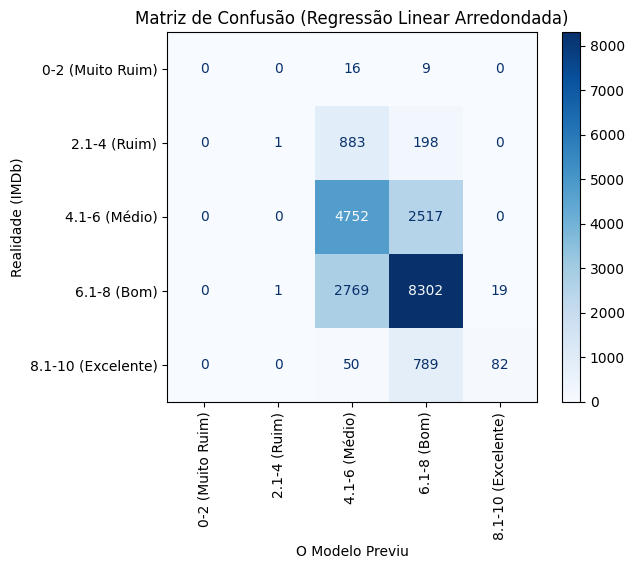

In [3]:
# --- 1. Converter Previsão Numérica (Regressão) para Classe (Classificação) ---
# Arredonda para o inteiro mais próximo (ex: 2.6 -> 3)
y_pred_classes = np.round(previsoes)

# Garante que não existam números fora do limite (menor que 0 ou maior que 4)
# Caso o modelo preveja -0.5 (vira 0) ou 5.2 (vira 4)
y_pred_classes = np.clip(y_pred_classes, 0, 4).astype(int)

# --- 2. Gerar a Matriz de Confusão ---
cm = confusion_matrix(y_test, y_pred_classes)

# --- 3. Visualizar ---
# Definindo os nomes das classes para ficar fácil de ler no gráfico
nomes_classes = ['0-2 (Muito Ruim)', '2.1-4 (Ruim)', '4.1-6 (Médio)', '6.1-8 (Bom)', '8.1-10 (Excelente)']

# Plotar
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nomes_classes)
disp.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')

plt.title('Matriz de Confusão (Regressão Linear Arredondada)')
plt.xlabel('O Modelo Previu')
plt.ylabel('Realidade (IMDb)')
plt.show()

Treinando SVM... (Isso pode demorar um pouquinho)


<Figure size 1000x800 with 0 Axes>

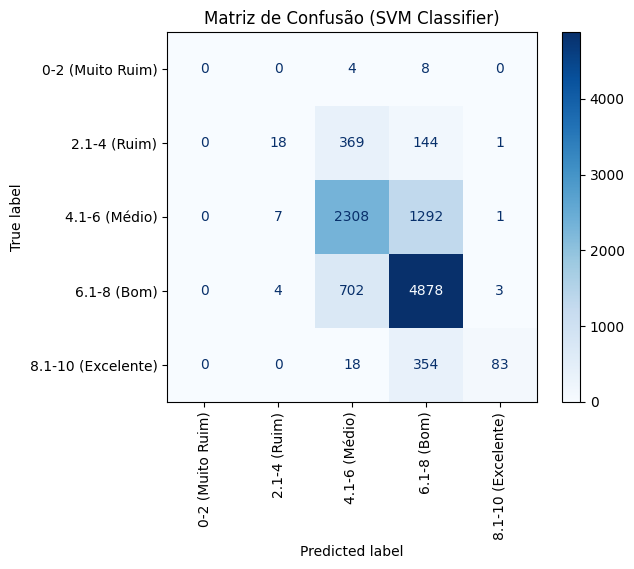


Relatório Detalhado:
                    precision    recall  f1-score   support

  0-2 (Muito Ruim)       0.00      0.00      0.00        12
      2.1-4 (Ruim)       0.62      0.03      0.06       532
     4.1-6 (Médio)       0.68      0.64      0.66      3608
       6.1-8 (Bom)       0.73      0.87      0.80      5587
8.1-10 (Excelente)       0.94      0.18      0.31       455

          accuracy                           0.71     10194
         macro avg       0.59      0.35      0.36     10194
      weighted avg       0.72      0.71      0.69     10194



In [ ]:
# 1. Carregar os Dados
IMDB = '../data/'
df = pd.read_csv(IMDB + 'filmes_series_imdb.csv')

# --- LIMPEZA E PREPARAÇÃO ---
if 'run_time_minutes' in df.columns:
    df['run_time_minutes'] = df['run_time_minutes'].astype(str).str.replace(r'\n', '', regex=True).str.strip()
    df['run_time_minutes'] = pd.to_numeric(df['run_time_minutes'], errors='coerce')

df = df.dropna(subset=['imdb_rating_concatenada'])

# 4. Definir X e y
colunas_features = ['release_year', 'run_time_minutes', 'number_votes'] + \
                   [c for c in df.columns if c.startswith('Genre_')] + \
                   [c for c in df.columns if c.startswith('Type_')] + \
                   [c for c in df.columns if c.startswith('Cast_')] + \
                   [c for c in df.columns if c.startswith('Dir_')] + \
                   [c for c in df.columns if c.startswith('Streaming_')]

X = df[colunas_features]
y = df['target']

# --- A MÁGICA DO SVM: ESCALONAMENTO ---
# SVM precisa que os dados estejam na mesma escala (média 0, desvio padrão 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.05 , random_state=42)

# 6. Criar e Treinar SVM
# kernel='rbf' é o padrão e geralmente o melhor para dados complexos
print("Treinando SVM... (Isso pode demorar um pouquinho)")
svm_modelo = SVC(kernel='rbf', random_state=42)
svm_modelo.fit(X_train, y_train)

# 7. Previsões
y_pred = svm_modelo.predict(X_test)

# --- VISUALIZAR MATRIZ DE CONFUSÃO ---
nomes_classes = ['0-2 (Muito Ruim)', '2.1-4 (Ruim)', '4.1-6 (Médio)', '6.1-8 (Bom)', '8.1-10 (Excelente)']
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nomes_classes)
disp.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')
plt.title('Matriz de Confusão (SVM Classifier)')
plt.show()

print("\nRelatório Detalhado:")
print(classification_report(y_test, y_pred, target_names=nomes_classes, zero_division=0))